In [23]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import math

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [24]:
df_train = pd.read_hdf('../data/data.h5', key="train")
df_val = pd.read_hdf('../data/data.h5', key="validation")
df_test = pd.read_hdf('../data/data.h5', key="test")

df_train = pd.concat([df_train, df_val])
df_train.sort_index(inplace=True)

## Feature engineering

In [79]:
def log_returns(series_prices):
    return np.log(series_prices).diff()

def trend(series):
    return (series[-1] - series[0]) / len(series)

def diff(series):
    return (series[-1] - series[0])

def diff_max(series):
    return np.max(series - series[0])

def diff_min(series):
    return np.min(series - series[0])

def diff_mean(series):
    return np.mean(series - series[0])

def preprocess_security_daily(df):
    df = df.copy()
    
    feature_fns = [np.mean, np.std, np.min, np.max, trend, diff_max, diff_min, diff_mean]
    
    last_days = [1, 2, 3, 4, 8, 32, 64, 128, 256]
    cols = df.columns
    for period in tqdm(last_days):
        for col in cols:
            for fn in feature_fns:
                new_col_name = col + "_" + fn.__name__ + '_' + str(period)
                new_col = df[col].rolling(period).apply(fn, engine='numba', raw=True)
                df[new_col_name] = new_col.reset_index(level=0, drop=True)
    return df

In [80]:
df_train_processed = preprocess_security_daily(df_train)

df_train_processed["hour"] = df_train_processed.index.hour
df_train_processed["cos_year_day"] = np.cos(2 * math.pi * pd.Series(df_train_processed.index).dt.day_of_year / 365)
df_train_processed["sin_year_day"] = np.sin(2 * math.pi * pd.Series(df_train_processed.index).dt.day_of_year / 365)

df_train_processed["cos_year_month"] = np.cos(2 * math.pi * pd.Series(df_train_processed.index).dt.month / 12)
df_train_processed["sin_year_month"] = np.sin(2 * math.pi * pd.Series(df_train_processed.index).dt.month / 12)

df_train_processed["cos_month"] = np.cos(2 * math.pi * pd.Series(df_train_processed.index).dt.day / 30)
df_train_processed["sin_month"] = np.sin(2 * math.pi * pd.Series(df_train_processed.index).dt.day / 30)

df_train_processed["cos_week"] = np.cos(2 * math.pi * pd.Series(df_train_processed.index).dt.day_of_week / 7)
df_train_processed["sin_week"] = np.sin(2 * math.pi * pd.Series(df_train_processed.index).dt.day_of_week / 7)

100%|█████████████████████████████████████████████| 9/9 [01:07<00:00,  7.51s/it]


## Training & evaluation pipeline

In [150]:
def data_split(data, target_name, td):
    from sklearn.model_selection import train_test_split
    data.sort_index(inplace=True)
    data['y'] = data[target_name].shift(-td)
    X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.05, shuffle=False, random_state=1)
    
    return np.array(data.index[:len(X_train)]), X_train, y_train, X_test, y_test

In [82]:
def train_lightgbm(X_train, y_train):
    import lightgbm as lgb
    
    model = lgb.LGBMRegressor(n_jobs=-1, force_col_wise=True, verbosity=0)
    model.fit(X_train, y_train)
    
    return model

In [138]:
def train_and_validate_lightgbm(X_train, y_train, td):
    train_size = int(len(X_train) * 0.95)
    
    X_tr = X_train[:train_size-td]
    y_tr = y_train[:train_size-td]
    
    X_val = X_train[train_size:]
    y_val = y_train[train_size:]
        
    model = train_lightgbm(X_tr, y_tr)
        
    y_hat = model.predict(X_val)
    
    return np.array(y_val), np.array(y_hat), model

In [158]:
def evaluate_lightgbm(idx, X_train, y_train, td, plot=False, plt_title=''):
    y, y_hat, model = train_and_validate_lightgbm(X_train, y_train, td)
    
    mae = np.mean(np.abs(np.array(y)-np.array(y_hat)))
    mse = np.mean(np.square(np.array(y)-np.array(y_hat)))
    
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt

        plt.figure(figsize=(18, 10))
        sns.lineplot(x=idx[-len(y):], y=y, label='Value')
        sns.lineplot(x=idx[-len(y):], y=y_hat, label='Predicted value')
        plt.title(plt_title)
    
    return mae, mse, model

Series mean: 0.7293304692611481
Series std: 0.3071823551171675
MAE: 0.20024296239150977
MSE: 0.08453590683416079


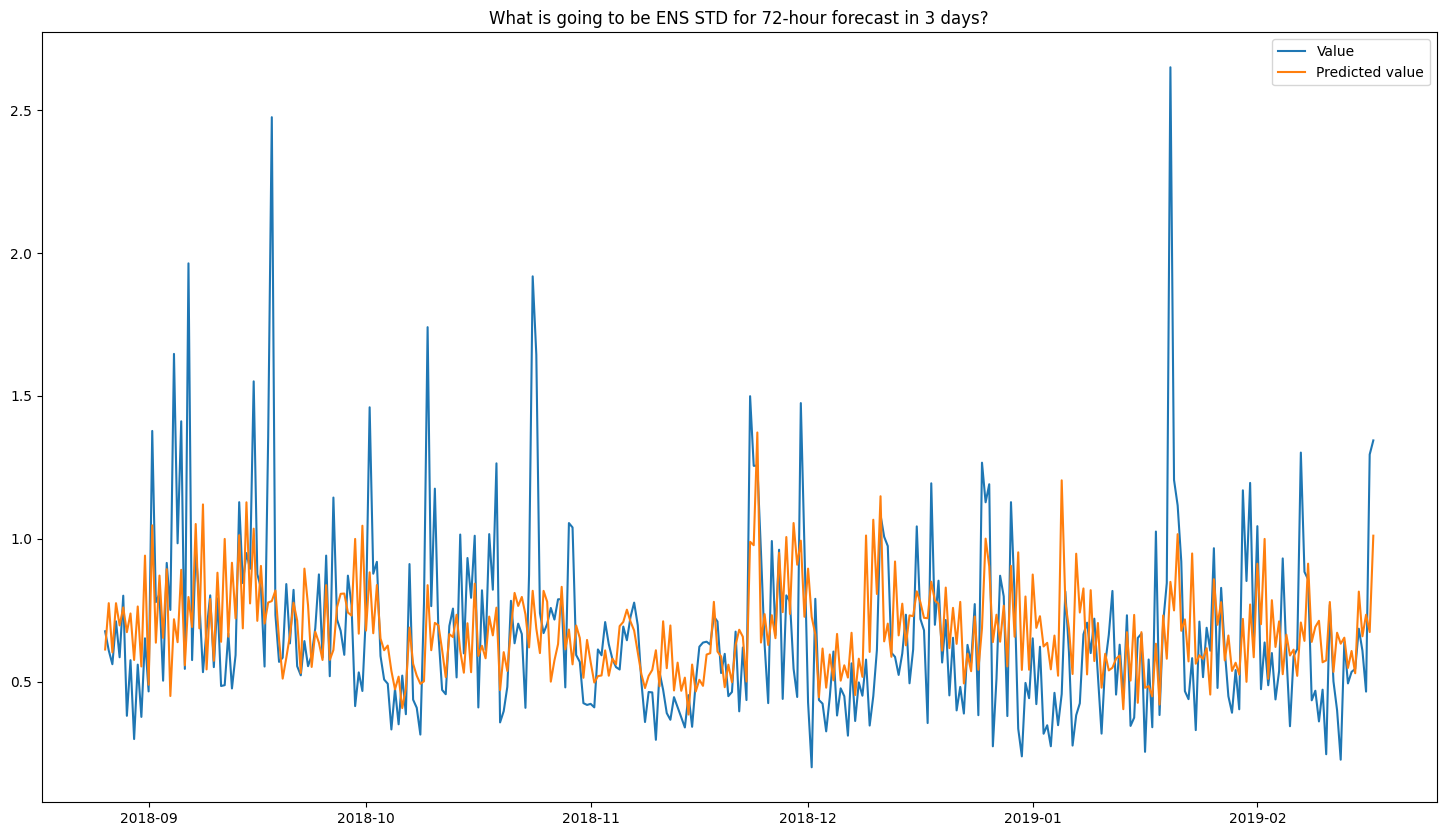

In [162]:
td = 6
target_name = 'ens_std-DEU_TEMP_EC15-72'

idx, X_train, y_train, X_test, y_test = data_split(df_train_processed, target_name, td)
    
mae, mse, model = evaluate_lightgbm(idx, X_train, y_train, td, True, 'What is going to be ENS STD for 72-hour forecast in 3 days?')

print(f"Series mean: {y_train.mean()}")
print(f"Series std: {y_train.std()}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

Series mean: 2.9359284184852377
Series std: 2.140255917341094
MAE: 1.2509282000867774
MSE: 2.488548031287001


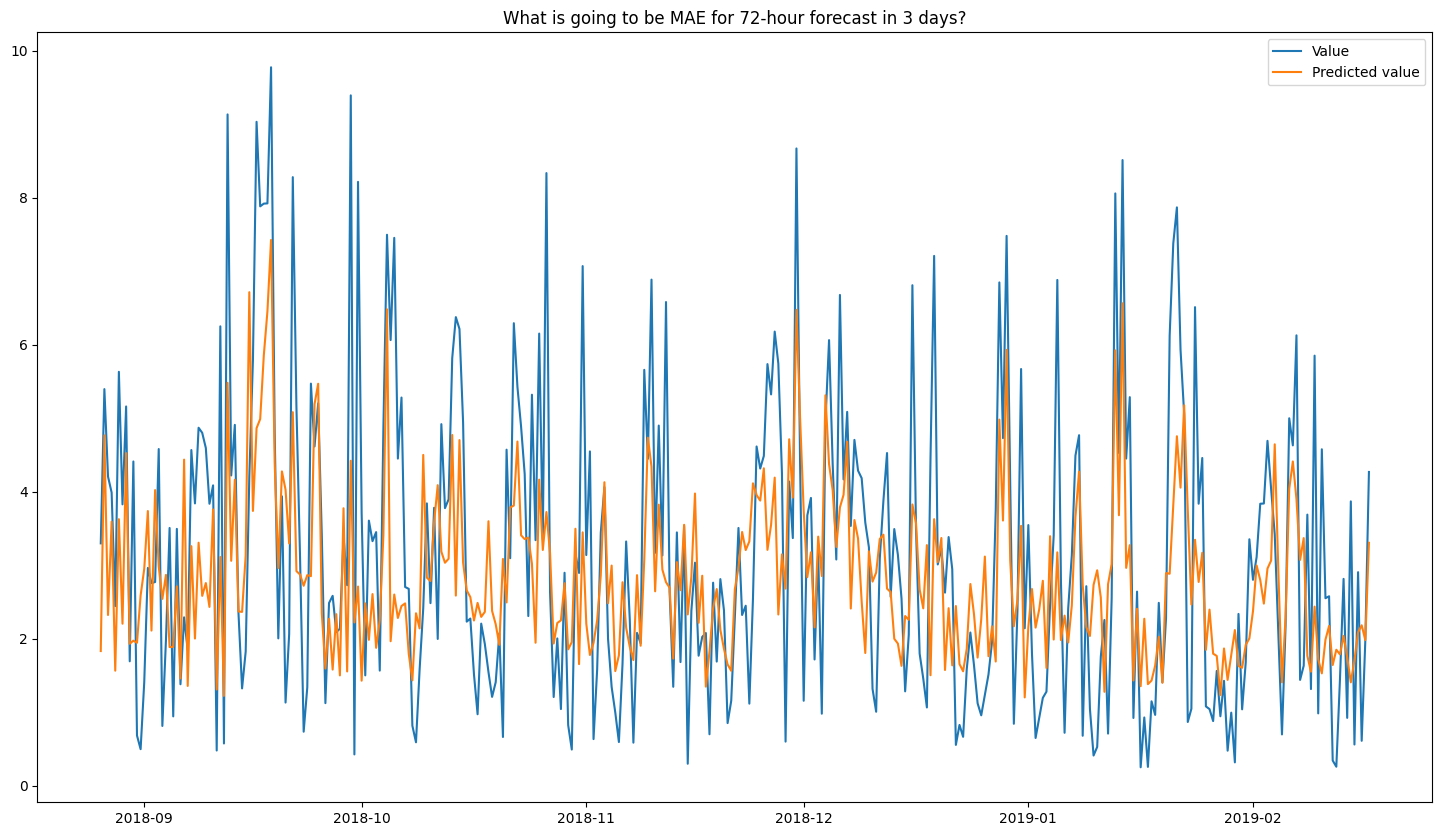

In [163]:
td = 6
target_name = 'mae-DEU_TEMP_EC15-72'

idx, X_train, y_train, X_test, y_test = data_split(df_train_processed, target_name, td)
    
mae, mse, model = evaluate_lightgbm(idx, X_train, y_train, td, True, 'What is going to be MAE for 72-hour forecast in 3 days?')

print(f"Series mean: {y_train.mean()}")
print(f"Series std: {y_train.std()}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

Series mean: 10.920144274238663
Series std: 7.97723093950499
MAE: 1.350670531315912
MSE: 3.078344574557153


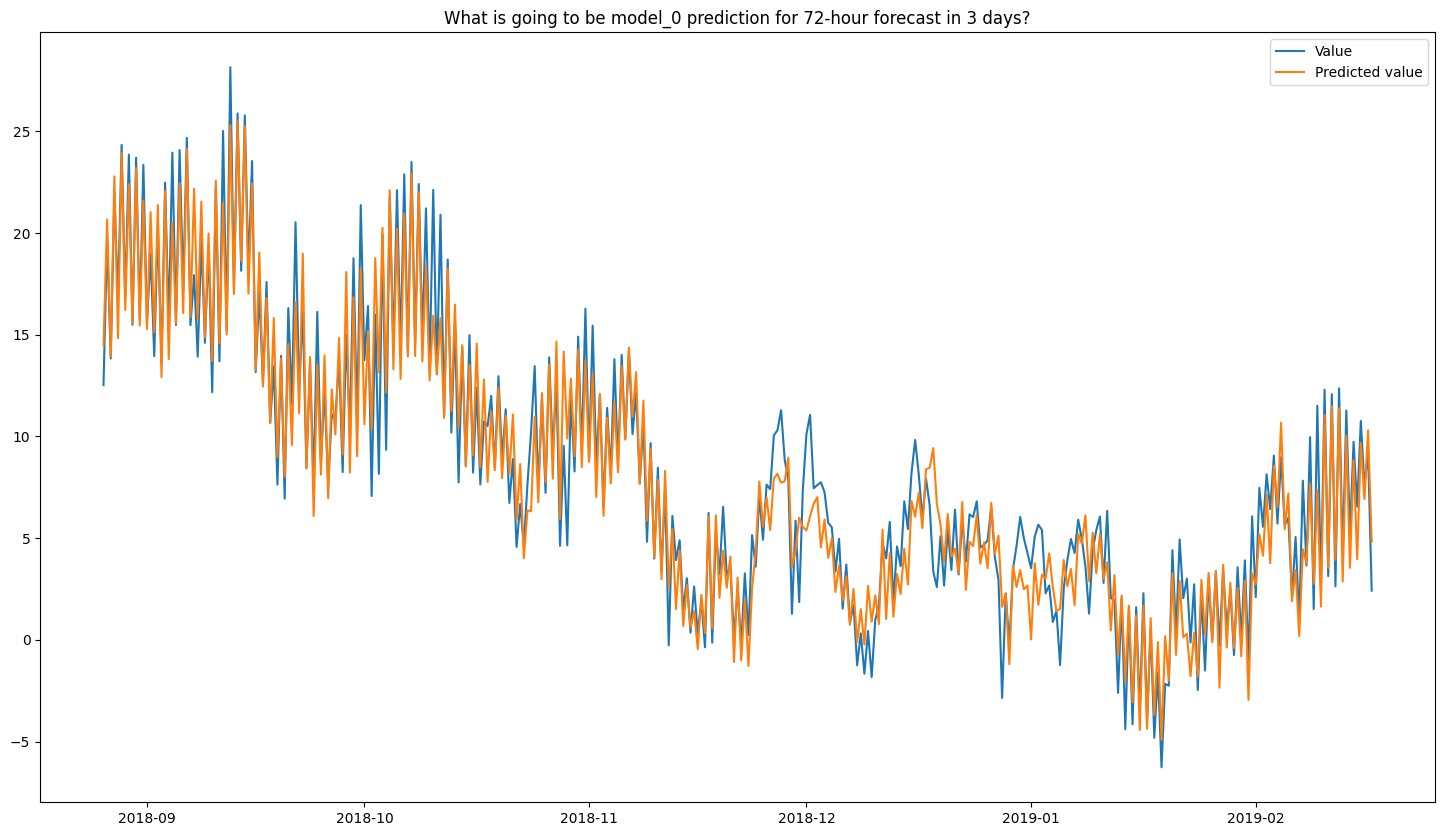

In [164]:
td = 6
target_name = 'model_0_value-DEU_TEMP_EC15-72'

idx, X_train, y_train, X_test, y_test = data_split(df_train_processed, target_name, td)
    
mae, mse, model = evaluate_lightgbm(idx, X_train, y_train, td, True, 'What is going to be model_0 prediction for 72-hour forecast in 3 days?')

print(f"Series mean: {y_train.mean()}")
print(f"Series std: {y_train.std()}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

In [ ]:
df_results = pd.DataFrame(columns=['column', 'col_mean', 'col_std', 'pred_mae', 'pred_mse'])

MEANs = []
STDs = []
MAEs = []
MSEs = []
td = 14
for col in tqdm(df_train.columns):
    X_train, y_train, _, _ = data_split(df_train_processed, col, td)
    
    mae, mse, model = evaluate_lightgbm(X_train, y_train, td)
    MEANs.append(y_train.mean())
    STDs.append(y_train.std())
    MAEs.append(mae)
    MSEs.append(mse)